### PyTorch Workflow

- [Load the data - clean and format it](#loadprep)
- Pick a model
- Start building the model
- Fit it with training data
- Evaluate it with test data
- Experiment and improve
- Save the model


In [1]:
## first the imports
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

<a id='loadprep'></a>
Loading and preparing the data

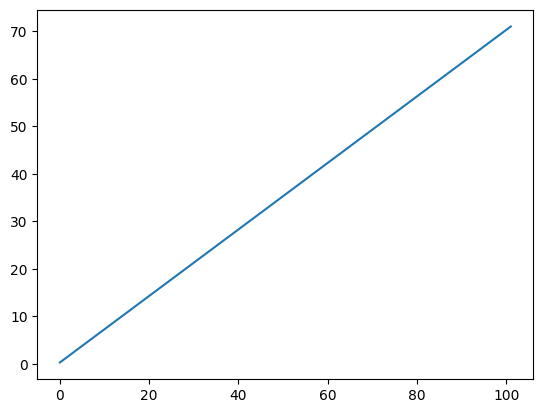

In [2]:
## lets start with a simple linear data
weight = .7
bias = .3
X = torch.linspace(0, 101, 500).unsqueeze(1)
y = weight * X + bias
_= plt.plot(X, y)

In [3]:
## splitting our data into
w = .7
b = .3
X_train, X_test = torch.split(X, (int(.8*X.shape[0]),int(.2*X.shape[0])))
y_f = lambda x:w*x + b
y_train, y_test = y_f(X_train), y_f(X_test)
len(X_train), len(X_test)

(400, 100)

### Creating our own linear Regression class
using:
- MAE for loss
- SGD as optimizer

In [10]:
## starting with a simple Linear Regression class
## setting the random seed
torch.manual_seed(0)
class LinearRegression(nn.Module):
  def __init__(self):
    ## overwritting the forward method in nn.Module
    super(LinearRegression, self).__init__()
    ## and defining our parameters
    ## which are just weight and bias
    ## and we will be using the nn.Parameter for creating them
    self.weight = nn.Parameter(torch.rand(1, ## just one random number to start
                                     requires_grad=True, ## having torch track the gradient
                                     dtype=torch.float32)) ## just to make things more verbose

    self.bias = nn.Parameter(torch.rand(1,
                                   requires_grad=True,
                                   dtype = torch.float32))
  ## and then defining our forward method
  ## which is used for forward pass calculations
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    ## this step simply returns the linear line equation
    return self.weight * x + self.bias

## and next we need to decide on the loss function
## and the optimizer for it
## we can use the mean absolute error
## or mean squared error
def loss(yhat, y):
  return torch.abs(yhat - y).mean()

## then we need an instance of the model
lr_model = LinearRegression()
## checking the parameters of the model
print(lr_model.state_dict())
## and then we need to choose an optimizer
## which we will use the SGD
learning_rate = 1e-3
optimizer = torch.optim.SGD(lr_model.parameters(),
                            lr=learning_rate)
## and next we need to create our trainig and test loops
epochs = 10000
for _ in range(epochs):
  ## setting our model to training mode
  lr_model.train()
  ## calculating our predictions
  yhat = lr_model(X_train)
  ## and then the loss for those predictions
  l = loss(yhat, y_train)
  ## zeroing the grad
  optimizer.zero_grad()
  ## claculating the backpropagation loss
  l.backward()
  ## and then taking a step
  optimizer.step()

## and then the test loop
## setting the gradient off
with torch.inference_mode():
  y_pred = lr_model(X_test)
  l = loss(y_pred, y_test)
  print(f'After {epochs} epochs, the loss for our predictions is {round(l.item(),2)}\n for the current values of {lr_model.state_dict()}\n The true values are weight:{w} and bias:{b}')

OrderedDict([('weight', tensor([0.4963])), ('bias', tensor([0.7682]))])
After 10000 epochs, the loss for our predictions is 3.67
 for the current values of OrderedDict([('weight', tensor([0.6594])), ('bias', tensor([0.3173]))])
 The true values are weight:0.7 and bias:0.3


### Using the linear model from nn

using:
- MSE for loss
- Adam as optimizer

Our test loss after 1000 epochs is 0.21. 
And calculated params are 
OrderedDict([('lin.weight', tensor([[0.6898]])), ('lin.bias', tensor([0.9786]))])

which should be w: 0.7, b: 0.3


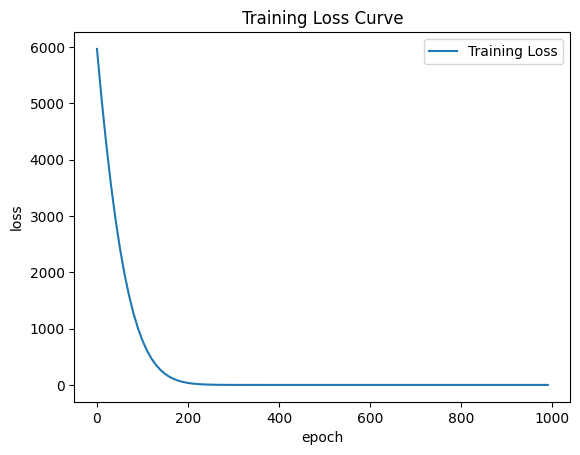

In [30]:
## lets try to find the weight and the bias

## first we need to set the requires_grad to true for X
## and then define the y as a function

def y_func(X, w, b):
  return w * X + b

## and then we need to define our loss func
## which will be a simple MSE
def loss(yhat, y):
  return ((yhat-y)**2).mean()

## and creating our simple linear regression class
class LinearRegression(nn.Module):
  def __init__(self, input_d, output_d):
    super(LinearRegression, self).__init__()
    self.lin = nn.Linear(input_d, output_d)
  def forward(self, X):
    return self.lin(X)

## lets create some sample data
X = torch.linspace(0, 100, 1000).unsqueeze(1)
X.requires_grad_ = True
w = .7
b = .3
y = y_func(X, w, b)

## we need an instance of our model
model = LinearRegression(X.shape[1], X.shape[1])

## we need a learning rate for our optimizer
learning_rate = 1e-2
## and finally the optimizer
## which we will use the nn module
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## now all we have to do is to train our model
epochs = 1000
track_dict = {}
for epoch in range(epochs):
  yhat = model(X)
  l = loss(yhat, y)
  l.backward()
  optimizer.step()
  optimizer.zero_grad()
  if epoch%10==0:
    track_dict[epoch] = l.item()

with torch.inference_mode():
  x = torch.linspace(101, 120, 200).unsqueeze(1)
  yhat = model(x)
  l = loss(yhat, y_func(x, w, b))
  print(f'Our test loss after {epochs} epochs is {round(l.item(), 2)}. \nAnd calculated params are \n{model.state_dict()}')
  print(f'\nwhich should be w: {w}, b: {b}')

plt.cla()
plt.clf()
_= plt.plot(*zip(*track_dict.items()), label='Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training Loss Curve')
_=plt.legend()

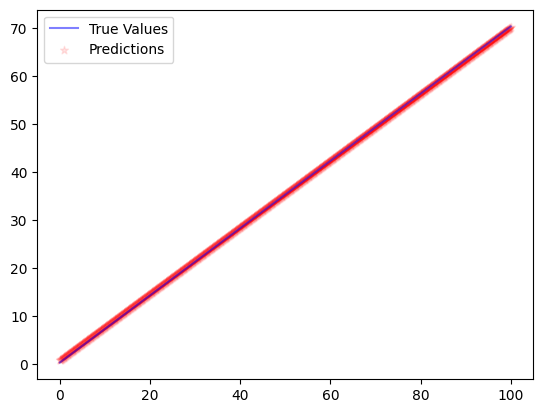

In [11]:
## plotting the prediction vs actuals
plt.plot(X, y, alpha=.5, color ='blue', label='True Values')
plt.scatter(X, model(X).detach(), alpha=0.1, color='red',
            marker='*', label='Predictions')
plt.legend()